# Food Vision

**Original Paper** -> https://arxiv.org/pdf/1606.05675.pdf

> Trying to beat the `77.4%` in `Top-1 accuracy` column with this notebook.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6195276c-e7cd-fa44-b14b-424b396634a7)


## Imports

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

import os
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

## Importing helper functions

In [ ]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-09 08:59:42--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18407 (18K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  17.98K  --.-KB/s    in 0.001s  

2022-08-09 08:59:43 (21.2 MB/s) - ‘helper_functions.py’ saved [18407/18407]



In [ ]:
from helper_functions import plot_loss_curves, compare_historys, create_data_augmented_layer_for_model, load_and_prep_image, make_confusion_matrix, make_confusion_matrix_for_larger_dataset

## Tensorflow Datasets

**Original Link** -> https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

**Food101 Dataset** -> https://www.tensorflow.org/datasets/catalog/food101

## Load the Data

In [ ]:
(train_data, test_data), ds_info= tfds.load(name="food101", split=["train", "validation"], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteBOYPUT/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteBOYPUT/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

## Exploring the Food101 Dataset

In [ ]:
class_names= ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
len(train_data)

75750

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_one_sample= train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class or Label from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 74
  Class name (str form): peking_duck
        


In [ ]:
image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[152, 129,  77],
        [160, 137,  85],
        [160, 137,  85],
        ...,
        [ 26,  21,  18],
        [ 24,  19,  16],
        [ 21,  16,  13]],

       [[156, 133,  81],
        [158, 135,  83],
        [155, 132,  80],
        ...,
        [ 25,  20,  17],
        [ 23,  18,  15],
        [ 22,  17,  14]],

       [[164, 141,  87],
        [159, 136,  82],
        [147, 124,  70],
        ...,
        [ 23,  18,  15],
        [ 21,  17,  14],
        [ 20,  16,  13]],

       ...,

       [[  1,  49, 121],
        [  0,  47, 119],
        [  0,  48, 120],
        ...,
        [ 26,  14,  16],
        [ 26,  14,  16],
        [ 32,  20,  22]],

       [[  1,  49, 121],
        [  0,  47, 119],
        [  0,  48, 120],
        ...,
        [ 24,  14,  15],
        [ 30,  18,  18],
        [ 30,  18,  18]],

       [[  2,  50, 122],
        [  0,  48, 120],
        [  0,  48, 120],
        ...,
        [ 22,  12,  1

In [ ]:
image.shape

TensorShape([512, 384, 3])

In [ ]:
image/255,

(<tf.Tensor: shape=(512, 384, 3), dtype=float32, numpy=
 array([[[0.59607846, 0.5058824 , 0.3019608 ],
         [0.627451  , 0.5372549 , 0.33333334],
         [0.627451  , 0.5372549 , 0.33333334],
         ...,
         [0.10196079, 0.08235294, 0.07058824],
         [0.09411765, 0.07450981, 0.0627451 ],
         [0.08235294, 0.0627451 , 0.05098039]],
 
        [[0.6117647 , 0.52156866, 0.31764707],
         [0.61960787, 0.5294118 , 0.3254902 ],
         [0.60784316, 0.5176471 , 0.3137255 ],
         ...,
         [0.09803922, 0.07843138, 0.06666667],
         [0.09019608, 0.07058824, 0.05882353],
         [0.08627451, 0.06666667, 0.05490196]],
 
        [[0.6431373 , 0.5529412 , 0.34117648],
         [0.62352943, 0.53333336, 0.32156864],
         [0.5764706 , 0.4862745 , 0.27450982],
         ...,
         [0.09019608, 0.07058824, 0.05882353],
         [0.08235294, 0.06666667, 0.05490196],
         [0.07843138, 0.0627451 , 0.05098039]],
 
        ...,
 
        [[0.00392157, 0.19215687

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from dataset

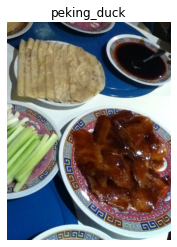

In [ ]:
plt.imshow(image/255)
plt.title(class_names[label.numpy()])
plt.axis(False);

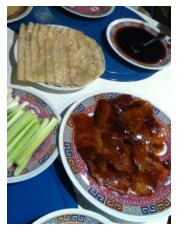

In [ ]:
plt.imshow(image)
plt.axis(False);

Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 64
    Class name (str form): miso_soup
Image shape: (512, 384, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 74
    Class name (str form): peking_duck
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 23
    Class name (str form): churros
Image shape: (384, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 97
    Class name (str form): takoyaki
Image shape: (384, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 49
    Class name (str form): grilled_cheese_sandwich
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tenso

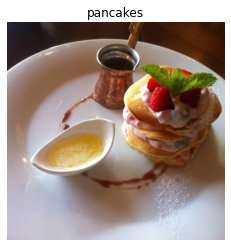

In [ ]:
train_one_sample=[]
for i in range(10):
  train_one_sample.append(train_data.take(1))
  for image, label in train_one_sample[i]:
    plt.imshow(image/255)
    plt.title(class_names[label.numpy()])
    plt.axis(False);
    print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
  

In [ ]:
train_one_sample= train_data.take(10)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Preprocessing function to preprocess our data

> Neural Network perform best when data is in a certain way(e.g. `batched, normalized, etc`)

> Before we pass, the data to the model for training, we need to do a few thing to the data for it to be eligiable to be passed to the model for training

### what are the problems with the data we have currently:-

* Images are in `uint8` datatype

* Images are of varying sizes

* Images are not scaled(between 0-1)

### What type of data, models like:

* Data needs to be in `float32` dtype(or for `mixed precision` in `float16 and float32`)

* For Batches, Tensorflow likes the images in a `constant/consistent/same size`.

* Normalized/scaled data(values between 0-1) speeds up the traning process and helps the model learn the patterns of the dataset faster

#### Working of the preprocessing function

* Reshaping all of the images to the same size
* Convert all of the dtypes of our image tensors from `uint8` to `float32` which models like.

In [ ]:
def preprocess_image(image, label, img_shape=224, scaling=False):
  """
    Converts any image datatype to 'float32', and reshapes the images to [img_shape, img_shape, color_channels]
    Args:
      image: The image to the preprocesses
      label: string, The label of the image
      img_shape: int, Default is '224'. The shape to which the image is preprocessed into.
    Returns:
      (newImage, label) respectively as a tupel

  """
  image= tf.image.resize(image, [img_shape, img_shape]) # Resizing the image into a same size.
  if scaling:
    image= image/255. # Scaling/Normalizing values of the image. EfficientNetBx models have build-in rescaling layers
  newdtypeImage= tf.cast(image, tf.float32) # Changing the dtype of the image into float32
  return newdtypeImage, label

### Trying the preprocessed function

In [ ]:
preprocessed_img, preprocessed_label= preprocess_image(image, label)

In [ ]:
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 41.127552 ,  39.127552 ,  50.127552 ],
        [ 40.642857 ,  38.642857 ,  49.642857 ],
        [ 40.285713 ,  38.285713 ,  49.285713 ],
        ...,
        [ 48.92855  ,  21.928549 ,   4.500022 ],
        [ 47.7398   ,  20.739801 ,   3.7398005],
        [ 49.301044 ,  22.301043 ,   5.3010426]],

       [[ 40.642857 ,  38.642857 ,  49.642857 ],
        [ 42.9949   ,  40.9949   ,  51.9949   ],
        [ 41.85714  ,  39.85714  ,  50.85714  ],
        ...,
        [ 49.127533 ,  22.127531 ,   4.699003 ],
        [ 47.862247 ,  20.862246 ,   3.8622463],
        [ 48.928574 ,  21.928572 ,   4.9285717]],

       [[ 42.07653  ,  39.862244 ,  50.862244 ],
        [ 41.071426 ,  38.85714  ,  49.85714  ],
        [ 38.663265 ,  36.44898  ,  47.44898  ],
        ...,
        [ 48.785713 ,  21.785713 ,   4.785714 ],
        [ 47.98469  ,  20.770405 ,   4.413263 ],
        [ 47.785713 ,  20.571428 ,   4.214286 ]],

       ...,

     

In [ ]:
preprocessed_img_1, preprocessed_label_1= preprocess_image(image, label, scaling=False)

In [ ]:
preprocessed_img_1

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 41.127552 ,  39.127552 ,  50.127552 ],
        [ 40.642857 ,  38.642857 ,  49.642857 ],
        [ 40.285713 ,  38.285713 ,  49.285713 ],
        ...,
        [ 48.92855  ,  21.928549 ,   4.500022 ],
        [ 47.7398   ,  20.739801 ,   3.7398005],
        [ 49.301044 ,  22.301043 ,   5.3010426]],

       [[ 40.642857 ,  38.642857 ,  49.642857 ],
        [ 42.9949   ,  40.9949   ,  51.9949   ],
        [ 41.85714  ,  39.85714  ,  50.85714  ],
        ...,
        [ 49.127533 ,  22.127531 ,   4.699003 ],
        [ 47.862247 ,  20.862246 ,   3.8622463],
        [ 48.928574 ,  21.928572 ,   4.9285717]],

       [[ 42.07653  ,  39.862244 ,  50.862244 ],
        [ 41.071426 ,  38.85714  ,  49.85714  ],
        [ 38.663265 ,  36.44898  ,  47.44898  ],
        ...,
        [ 48.785713 ,  21.785713 ,   4.785714 ],
        [ 47.98469  ,  20.770405 ,   4.413263 ],
        [ 47.785713 ,  20.571428 ,   4.214286 ]],

       ...,

     

original Image
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 72
    Class name (str form): pancakes


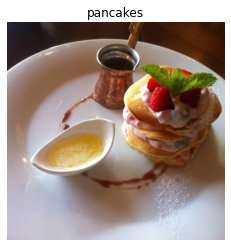

In [ ]:
print("original Image")
plt.imshow(image)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

Preprocessed Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 72
    Class name (str form): pancakes


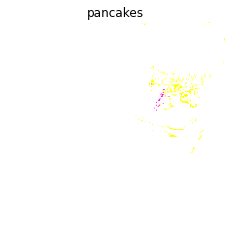

In [ ]:
print("Preprocessed Image")
plt.imshow(preprocessed_img)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {preprocessed_img.shape} Image dtype: {preprocessed_img.dtype} Target class or Label from Food101 (tensor form): {preprocessed_label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

Preprocessed Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 72
    Class name (str form): pancakes


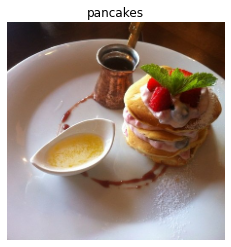

In [ ]:
print("Preprocessed Image")
plt.imshow(preprocessed_img_1/255)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {preprocessed_img_1.shape} Image dtype: {preprocessed_img_1.dtype} Target class or Label from Food101 (tensor form): {preprocessed_label_1}
    Class name (str form): {class_names[preprocessed_label_1.numpy()]}""")
plt.axis(False);

## Creating batches of the dataset and preparing the datasets

**Resources** -> https://www.tensorflow.org/guide/data_performance

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Mapped the preprocessing function to training data
train_data= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Tensorflow is going to automatically, tune the number of process the function uses.

# Shuffle train_data and turn it into batches and prefetch it(loading the data faster)
train_data= train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # It is going to shuffle 1000 sampples at a time

# Mapped the preprocessing function to test data
test_data= test_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_data_processes

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Explanation

"Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batc

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Create Modelling callbacks

In [ ]:
from helper_functions import  create_tensorboard_callback, model_check_point_callback, create_early_stopping_callback, reduce_learning_rate_callback

In [ ]:
# Model Checkpoint Callback
checkpoint_feature_extraction= 'checkpoints/feature_extraction_model'
checkpoint_callback=model_check_point_callback(checkpoint_feature_extraction, save_weights_only=True, save_best_only=True, monitor="val_loss")

# Tensorboard Callback
tensorboard_callback= create_tensorboard_callback("transfer_learning", "101_classes_feature_extraction_all_data")

# Early Stopping Callback
early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=5)

# Learning Rate Scheduler

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Reduce Learing Rate Callback

learning_rate_reduce_callback= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_feature_extraction_all_data/20220809-090710


## Mixed Precision Training

> Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

**Guide** -> https://www.tensorflow.org/guide/mixed_precision

## Adding Augmented Layer

In [ ]:
augmented_layer=create_data_augmented_layer_for_model(RandomFlip="horizontal", RandomRotation=0.2, RandomZoom=0.2, RandomHeight=0.2, RandomWidth=0.2)
augmented_layer

## Turnining on Mixed Precision Training


In [ ]:
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
len(class_names)

101

In [ ]:
CLASS_COUNT=len(class_names)

## Build Feature extraction model

> We will be using `Augmented, Dropout, Regularization` layers to reduce `overfitting` of the model. We will be using `Learning rate Scheduler` as well.

> Try once with `Learning Rate Scheduler` and use `learning rate callback` instead

In [ ]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x= augmented_layer(inputs)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x=  tf.keras.layers.Dropout(0.2)(x, name="dropout_layer") # Dropout Layer
x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5), name='regularization_layer')(x) # Regularization Layer
x = layers.Dense(CLASS_COUNT)(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

## Checking the layers of the model

* `layer.name` -> Human readable name of the layer
* `layer.trainable` -> Boolean, layer is trainable or not, if the layers are frozen or unfrozen
* `layer.dtype` -> The dtype format in which the layer stores the variables in

* `layer.dtype_policy` -> The dype_policy in which the layer computes the variables in

## Checking the dtype_policy of the layer of the base_model

In [ ]:
for layer in base_model.layers:
  print(layer, layer.name, layer.dtype, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x7f15303d4190> input_1 float32 <Policy "float32">
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f152b1c4e50> rescaling float32 <Policy "mixed_float16">
<keras.layers.preprocessing.normalization.Normalization object at 0x7f152b1c4690> normalization float32 <Policy "mixed_float16">
<keras.layers.convolutional.ZeroPadding2D object at 0x7f152b3a54d0> stem_conv_pad float32 <Policy "mixed_float16">
<keras.layers.convolutional.Conv2D object at 0x7f15303d7a10> stem_conv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f152b3acf50> stem_bn float32 <Policy "mixed_float16">
<keras.layers.core.activation.Activation object at 0x7f152a9e0750> stem_activation float32 <Policy "mixed_float16">
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f152b1e1810> block1a_dwconv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormal

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

## Training the feature_extraction layer

In [ ]:
history_101_food_classes_feature_extract = model.fit(train_data, epochs=10,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback, lr_scheduler_callback, learning_rate_reduce_callback])

In [ ]:
model.evaluate(test_data)

In [ ]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [ ]:
result_feature_extraction= model.evaluate(test_data)
result_feature_extraction

## Saving the model

In [ ]:
saved_model_dir='saved_models/model_feature_extraction_model'

In [ ]:
model.save(saved_model_dir)

INFO:tensorflow:Assets written to: saved_models/model_feature_extraction_2/assets


INFO:tensorflow:Assets written to: saved_models/model_feature_extraction_2/assets


## Downloading the saved models

In [ ]:
!zip -r saved_model_dir

  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/model_feature_extraction_2/ (stored 0%)
  adding: content/saved_models/model_feature_extraction_2/saved_model.pb (deflated 91%)
  adding: content/saved_models/model_feature_extraction_2/variables/ (stored 0%)
  adding: content/saved_models/model_feature_extraction_2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_models/model_feature_extraction_2/variables/variables.index (deflated 73%)
  adding: content/saved_models/model_feature_extraction_2/keras_metadata.pb (deflated 96%)
  adding: content/saved_models/model_feature_extraction_2/assets/ (stored 0%)


## Downloading the saved model from Colab

In [ ]:
from google.colab import files
files.download('/content/saved_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Loading and Evaluating the Checkpoint Weights

* tf.keras.models.clone_model()
* load_weights()
* evaluate()

### Trying to Clone the Feature Extracted Model with `clone_model()`

In [ ]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

In [ ]:
model.summary()

In [ ]:
checkpoint_feature_extraction

In [ ]:
cloned_model.load_weights(checkpoint_feature_extraction)

## We have to recompile the model each time we make some changes to the original model

In [ ]:
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)
results_cloned_model_with_loaded_weights

In [ ]:
results_cloned_model_with_loaded_weights == result_feature_extraction

In [ ]:
np.allclose(results_cloned_model_with_loaded_weights, result_feature_extraction)

## Load the saved Feature Extraction Model

In [ ]:
loaded_model= tf.keras.models.load_model(saved_model_dir)

In [ ]:
loaded_model_result=loaded_model.evaluate(test_data_processes)
loaded_model_result

790/790 [==============================] - 50s 61ms/step - loss: 1.0397 - accuracy: 0.7194


[1.0396966934204102, 0.7193663120269775]

In [ ]:
result_feature_extraction

[1.0396970510482788, 0.7193663120269775]

## Checking if the model saved/loaded correctly

In [ ]:
loaded_model_result == result_feature_extraction

False

In [ ]:
np.allclose(result_feature_extraction,loaded_model_result)

True

## Checking the layers of the loaded model

In [ ]:
for layer in loaded_model.layers:
  print(layer, layer.name, layer.trainable)

## Checking the dtype_policy of the loaded model

In [ ]:
for layer in loaded_model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

## Unfreezing all the layers of the base_model i.e EfficientNetB0 for Fine-Tuning

In [ ]:
for layer in loaded_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.dtype, layer.dtype_policy, layer.trainable)

In [ ]:
for layer in loaded_model.layers[1].layers:
  print(layer, layer.name, layer.trainable)

In [ ]:
for layer in loaded_model.layers[1].layers:
  if layer.trainable == False:
    print(layer, layer.name, layer.trainable)

In [ ]:
for layer in base_model.layers:
  if layer.trainable == True:
    print(layer, layer.name)

<keras.engine.input_layer.InputLayer object at 0x7f15303d4190> input_1
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f152b1c4e50> rescaling
<keras.layers.preprocessing.normalization.Normalization object at 0x7f152b1c4690> normalization
<keras.layers.convolutional.ZeroPadding2D object at 0x7f152b3a54d0> stem_conv_pad
<keras.layers.convolutional.Conv2D object at 0x7f15303d7a10> stem_conv
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f152b3acf50> stem_bn
<keras.layers.core.activation.Activation object at 0x7f152a9e0750> stem_activation
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f152b1e1810> block1a_dwconv
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f152a9cfd10> block1a_bn
<keras.layers.core.activation.Activation object at 0x7f15303d7990> block1a_activation
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f152b3912d0> block1a_se_squeeze
<keras.layers.core.reshape.Reshape ob

In [ ]:
len(loaded_model.layers)

5

In [ ]:
len(loaded_model.trainable_variables)

2

In [ ]:
len(base_model.trainable_variables)

211

In [ ]:
len(base_model.layers)

237

## Callback for Fine-Tuning All unfrozen layers

In [ ]:
checpoint_fine_tuning= "checkpoints_fine_tuning_all"

checkpoint_callback_fine_tuning_all_unfrozen=model_check_point_callback(checpoint_fine_tuning, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
tensorboard_callback_fine_tuning_all_unfrozen= create_tensorboard_callback("transfer_learning", "101_classes_fine_tuning_all_data_all_unfrozen_layers")
early_stopping_callback_fine_tuning_all_unfrozen= create_early_stopping_callback(monitor="val_loss", patience=5)
learning_rate_reduce_callback_all_unfrozen= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_fine_tuning_all_data_all_unfrozen_layers/20220809-101226


## Recompiling the model before Fine-Tuning

In [ ]:
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

## Fine-Tuning for all unfrozen layers

In [ ]:
history_fine_tuned_all= loaded_model.fit(train_data, epochs=100, steps_per_epoch=len(train_data) ,validation_data= test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[checkpoint_callback_fine_tuning_all_unfrozen, tensorboard_callback_fine_tuning_all_unfrozen, early_stopping_callback_fine_tuning_all_unfrozen, learning_rate_reduce_callback_all_unfrozen])

Epoch 1/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6910 - accuracy: 0.8282
Epoch 1: val_accuracy improved from -inf to 0.71663, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 175s 70ms/step - loss: 0.6909 - accuracy: 0.8282 - val_loss: 1.0425 - val_accuracy: 0.7166 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.8288
Epoch 2: val_accuracy improved from 0.71663 to 0.71928, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 167s 70ms/step - loss: 0.6876 - accuracy: 0.8288 - val_loss: 1.0358 - val_accuracy: 0.7193 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.8300
Epoch 3: val_accuracy did not improve from 0.71928
2368/2368 [==============================] - 167s 70ms/step - loss: 0.6845 - accuracy: 0.8300 - val_loss: 1.0381 - val_accuracy: 0.7190 - lr: 1.0000e

In [ ]:
loaded_model.summary()

In [ ]:
result_loaded_model_2=loaded_model.evaluate(test_data)
result_loaded_model_2

790/790 [==============================] - 48s 60ms/step - loss: 1.0435 - accuracy: 0.7190


[1.0434802770614624, 0.7189702987670898]

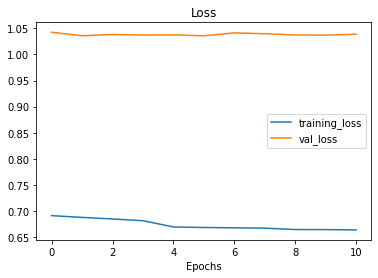

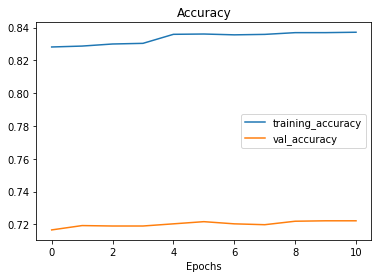

In [ ]:
plot_loss_curves(history_fine_tuned_all)

## Viewing/Comparing results on tensorboard


Link -> https://tensorboard.dev/experiment/8RDC0W82QkCB22MQyuYhag/#scalars

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning on the Food101 dataset" \
--description "Training a Transfer Learning model with EfficientNetB0 to beat the DeepFood paper which is based on the Food101 dataset." \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 

In [ ]:
!tensorboard dev list

## Evaluating `loaded_model_2`

In [ ]:
pred_probs=loaded_model_2.predict(test_data_processes, verbose=1)

In [ ]:
len(pred_probs)

In [ ]:
pred_probs.shape

In [ ]:
pred_probs[1]

In [ ]:
pred_classes= pred_probs.argmax(axis=1)

pred_classes[:5]

In [ ]:
len(pred_classes)

In [ ]:
y_labels= []

for images, labels in test_data_processes.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels

In [ ]:
len(y_labels)

## Accuracy Score

In [ ]:
sklearn_accuracy= accuracy_score(y_true= y_labels, y_pred= pred_classes)
sklearn_accuracy

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_labels, pred_classes)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]==0
fig, ax = plt.subplots(figsize=(100,100))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Classification Report 

In [ ]:
print(classification_report(y_true= y_labels, y_pred= pred_classes))

In [ ]:
classification_report_dict= classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

## Visualizing the F1-score

In [ ]:
class_f1_scores= {}

# Looping through the classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break

  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]


class_f1_scores

In [ ]:
f1_scores= pd.DataFrame({"class_names": list(class_f1_scores.keys()), "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Making Predictions on a series of random images

In [ ]:
train_dir='101_food_classes_10_percent/train'
test_dir='101_food_classes_10_percent/test'

In [ ]:
plt.figure(figsize=(40,10))
for i in range(15):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  img_expanded=tf.expand_dims(img, axis=0)
  pred_prob = model_final.predict(img_expanded) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(3, 5, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

In [ ]:
filepaths= []

for path in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg', shuffle= False):

  filepaths.append(path.numpy())

In [ ]:
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

In [ ]:
wrong_pred_df= pred_df[pred_df['pred_correct'] == False].sort_values("pred_conf", ascending=False)
wrong_pred_df

In [ ]:
images_to_view = 15
start_index = 32 # change the start index to view more
plt.figure(figsize=(30, 20))
for i, row in enumerate(wrong_pred_df[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 5, i+1)
  img = load_and_prep_image(row[1], scale=True) # 'row[1]' gives you the img path
  _, _, _, _, pred_conf, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \n prob: {pred_conf:.2f}")
  plt.axis(False)

## Evaluating on custom dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

In [ ]:
unzip_data('custom_food_images.zip')

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model_final.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)